In [1]:
import numpy as np
from matplotlib import pyplot as plt
from unet import UNet, xymDatasetMultiVar
import torch
import torch.optim as optim

In [2]:
## specify directories for data
y_var_dir = '../../../data/y_tiles/'
x_var_dir = '../../../data/x_tiles/'
land_mask_dir = '../../../data/land_mask/'

# create the dataset class
test_xym = xymDatasetMultiVar(y_var_dir, x_var_dir, land_mask_dir, y_transform=None, x_transform=None, ig_types=['Arson', 'Railroad', 'Powerline'], x_var=['aet-95th', 'aet-mean'], pad_result=True)
        

In [3]:
test_xym[0][0].shape, test_xym[1][0].shape, test_xym[2][0].shape, test_xym[3][0].shape,

test_xym[0][1].shape, test_xym[1][1].shape, test_xym[2][1].shape, test_xym[3][1].shape,

test_xym[0][2].shape, test_xym[1][2].shape, test_xym[2][2].shape, test_xym[3][2].shape,

(torch.Size([1, 448, 448]),
 torch.Size([1, 448, 448]),
 torch.Size([1, 448, 448]),
 torch.Size([1, 448, 448]))

In [4]:
## set up the UNet model
## 2 x_var, 3 y_var
model = UNet(in_channels=2, n_classes=3, depth=5, wf=6, padding=True, batch_norm=False, up_mode='upconv')

In [5]:
## do a sample forward pass
test_y = test_xym[0][0]
test_x = test_xym[0][1]
test_m = test_xym[0][2]
test_fwd = model.forward(torch.unsqueeze(test_x,0))

In [6]:
test_x.dtype, test_y.dtype, test_m.dtype

(torch.float32, torch.float32, torch.float32)

In [7]:
## set up a training pass
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
criterion = torch.nn.PoissonNLLLoss(full=True)

# set up the dataloader
trainloader = torch.utils.data.DataLoader(test_xym, batch_size=4, shuffle=True, num_workers=1)

# run through a couple epochs
losses = []
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader):
        print(i)
        if i>100:
            break
            
        # get the inputs
        labels, inputs, mask = data
        #print(labels.shape)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        losses.append(loss.item())
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

# mask the inputs for loss calculation
#loss(torch.masked_select(input=y_hat_tensor, mask = mask_tensor), torch.masked_select(input=y_tensor, mask=mask_tensor))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
Finished Training


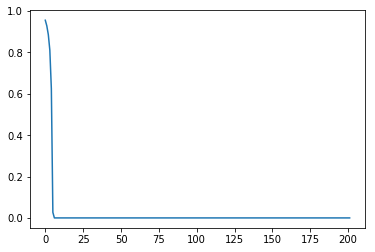

In [8]:
from matplotlib import pyplot as plt
plt.plot(losses)

## IMPLEMENT MASKED POISSON LOSS

In [7]:
model_ma = UNet(in_channels=2, n_classes=3, depth=5, wf=6, padding=True, batch_norm=False, up_mode='upconv')
optimizer_ma = optim.Adam(model_ma.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
criterion_ma = torch.nn.PoissonNLLLoss(full=True)

# set up the dataloader
trainloader_ma = torch.utils.data.DataLoader(test_xym, batch_size=4, shuffle=True, num_workers=1)

losses_ma = []
for epoch in range(1):  # loop over the dataset one times

    for i, data in enumerate(trainloader_ma):
        print(i)
        if i>100:
            break
            
        # get the inputs
        labels, inputs, mask = data
        mask = mask.byte()
        #print(labels.shape)

        # zero the parameter gradients
        optimizer_ma.zero_grad()

        # forward + backward + optimize
        outputs = model_ma(inputs)
        
        # masked loss
        masked_y_hat = torch.masked_select(input=outputs, mask=mask)
        masked_labels = torch.masked_select(input=labels, mask=mask)
        loss_ma = criterion_ma(masked_y_hat, masked_labels)
        loss_ma.backward()
        optimizer_ma.step()
        
        losses_ma.append(loss_ma.item())

0
1
2
3
4
5
6
7
8
9
10


KeyboardInterrupt: 

In [13]:
loss_ma.item()

nan

## DEBUG STUFF

In [ ]:
# for i in range(len(test_xym)):
#     print(i, test_xym[i][2].shape)
import glob, os, rasterio
files = glob.glob(r'C:\Projects\wildfire_nate\data\tile_tifs\*.tif')

for fi in files:
    with rasterio.open(fi) as src:
        shp = src.read().shape
        if (shp[1] != 448) | (shp[2] != 448):
            print(os.path.basename(fi), shp)

In [ ]:
files = glob.glob(r'C:\Projects\wildfire_nate\data\tile_tifs\*.tif')
new_path = r'C:\Projects\wildfire_nate\data\tile_tifs\new'
if not os.path.exists(new_path):
    os.mkdir(new_path)

for fi in files:
    with rasterio.open(fi) as src:
        profile = src.profile
        arr = src.read()
        arr *= 0
        arr += int(os.path.basename(fi).split('.')[0][1:])
        
    dest_fi = os.path.join(new_path, os.path.basename(fi))
    with rasterio.open(dest_fi, 'w', **profile) as dest:
        dest.write(arr)

In [ ]:
tile_fi = r'C:\Projects\wildfire_nate\data\tiles\tiles.shp'

import geopandas as gpd

tiles_df = gpd.read_file(tile_fi)

In [ ]:
tiles_df.head()

In [ ]:
## make a temp column to store image dims
tiles_df['temp'] = 0

# set a 'good dimension' variable
good_dims = 448*448

# iterate through the tiles
names = tiles_df.Name
for i,name in enumerate(names):
    raster_fi = os.path.join(r'C:\Projects\wildfire_nate\data\tile_tifs', f'{name}.tif')
    with rasterio.open(raster_fi) as src:
        shp = src.read().shape
        dims = shp[1]*shp[2]
        
        if dims != good_dims:
            tiles_df.iloc[i, tiles_df.columns.get_loc('temp')] = 1
#             df.iloc[0, df.columns.get_loc('COL_NAME')] = x
        
            
    

In [ ]:
tiles_df.temp.unique()

In [ ]:
tiles_df.head()

In [ ]:
tiles_df.plot(column='temp', alpha=0.4, figsize=(20,10))